# Data preperation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.formula.api import logit
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils import resample
from statsmodels.stats.proportion import proportions_ztest

# Load data
df = pd.read_csv("results.csv")

# Binary encode predictions (assumes labels are "male"/"female")
df["llama_pred_bin"] = df["llama_pred"].map({"female": 1, "male": 0,"unknown": -1})
df["gemma_pred_bin"] = df["gemma_pred"].map({"female": 1, "male": 0,"unknown": -1})

# Make sure actual_gender is binary
df["actual_gender"] = df["actual_gender"].astype(int) 

# Add binary correct predictions
df["llama_correct"] = df["llama_pred_bin"] == df["actual_gender"]
df["gemma_correct"] = df["gemma_pred_bin"] == df["actual_gender"]

# set ethnicities to 1-5 instead of 0-4
df["ethnicity"]= df['ethnicity']+1
df


,image,ethnicity,actual_gender,llama_pred,gemma_pred,llama_pred_bin,gemma_pred_bin,llama_correct,gemma_correct
0,./data/UTKFaceData/26_1_2_20170116184521807.jpg,3.0,1,female,female,1.0,1,True,True
1,./data/UTKFaceData/26_0_1_20170105183906447.jpg,2.0,0,male,male,0.0,0,True,True
2,./data/UTKFaceData/58_0_1_20170113185227312.jpg,2.0,0,male,male,0.0,0,True,True
3,./data/UTKFaceData/42_0_2_20170112215219256.jpg,3.0,0,male,male,0.0,0,True,True
4,./data/UTKFaceData/6_1_3_20170104222751249.jpg,4.0,1,female,female,1.0,1,True,True
...,...,...,...,...,...,...,...,...,...
2495,./data/UTKFaceData/46_1_4_20170104172709843.jpg,5.0,1,female,female,1.0,1,True,True
2496,./data/UTKFaceData/40_1_0_20170105164619947.jpg,1.0,1,female,female,1.0,1,True,True
2497,./data/UTKFaceData/2_0_2_20161219194834811.jpg,3.0,0,male,male,0.0,0,True,True
2498,./data/UTKFaceData/37_0_2_20170119193342866.jpg,3.0,0,male,male,0.0,0,True,True


# Ethnicities

## McNemar tests for ethnicities

In [10]:
from collections import defaultdict

def run_mcnemar_test(sub_df):
    a = np.sum((sub_df["llama_correct"]) & (sub_df["gemma_correct"]))
    b = np.sum((sub_df["llama_correct"]) & (~sub_df["gemma_correct"]))
    c = np.sum((~sub_df["llama_correct"]) & (sub_df["gemma_correct"]))
    d = np.sum((~sub_df["llama_correct"]) & (~sub_df["gemma_correct"]))
    table = [[a, b], [c, d]]
    result = mcnemar(table, exact=True)
    return result.statistic, result.pvalue

# Overall McNemar's test
stat, p = run_mcnemar_test(df)
print(f"🔍 Overall McNemar’s test:\n  Statistic = {stat:.3f}, p-value = {p:.2e}")

# Per set McNemar's test
sets = df["ethnicity"].unique()
for s in sets:
    subset = df[df["ethnicity"] == s]
    stat, p = run_mcnemar_test(subset)
    print(f"📦 Ethnicity {s:} McNemar's test: Statistic = {stat:.3f}, p = {p:.2e}")


🔍 Overall McNemar’s test:
  Statistic = 39.000, p-value = 1.57e-106
📦 Ethnicity 3.0 McNemar's test: Statistic = 19.000, p = 1.47e-20
📦 Ethnicity 2.0 McNemar's test: Statistic = 5.000, p = 2.28e-31
📦 Ethnicity 4.0 McNemar's test: Statistic = 3.000, p = 3.59e-26
📦 Ethnicity 1.0 McNemar's test: Statistic = 3.000, p = 1.86e-16
📦 Ethnicity 5.0 McNemar's test: Statistic = 9.000, p = 2.99e-19


## Bootstrapping for accuracy differences 

In [9]:
def bootstrap_ci(data, col1, col2, n_bootstrap=1000, ci=95):
    boot_diffs = []
    for _ in range(n_bootstrap):
        sample = resample(data)
        acc1 = (sample[col1] == sample["actual_gender"]).mean()
        acc2 = (sample[col2] == sample["actual_gender"]).mean()
        boot_diffs.append(acc1 - acc2)
    lower = np.percentile(boot_diffs, (100 - ci) / 2)
    upper = np.percentile(boot_diffs, 100 - (100 - ci) / 2)
    return np.mean(boot_diffs), (lower, upper)

# Overall CI
mean_diff, (ci_low, ci_high) = bootstrap_ci(df, "gemma_pred_bin", "llama_pred_bin")
print(f"📊 Accuracy difference (Gemma - Llama): {mean_diff:.3f}, 95% CI = [{ci_low:.3f}, {ci_high:.3f}]")

# Per set
for s in sets:
    subset = df[df["ethnicity"] == s]
    mean_diff, (ci_low, ci_high) = bootstrap_ci(subset, "gemma_pred_bin", "llama_pred_bin")
    print(f"📦 Ethnicity {s}: Mean acc diff = {mean_diff:.3f}, CI = [{ci_low:.3f}, {ci_high:.3f}]")


📊 Accuracy difference (Gemma - Llama): 0.190, 95% CI = [0.174, 0.205]
📦 Ethnicity 3.0: Mean acc diff = 0.214, CI = [0.170, 0.256]
📦 Ethnicity 2.0: Mean acc diff = 0.242, CI = [0.202, 0.284]
📦 Ethnicity 4.0: Mean acc diff = 0.195, CI = [0.158, 0.228]
📦 Ethnicity 1.0: Mean acc diff = 0.126, CI = [0.094, 0.158]
📦 Ethnicity 5.0: Mean acc diff = 0.172, CI = [0.138, 0.208]


In [35]:
from sklearn.metrics import precision_score, recall_score

def bootstrap_metric_ci(y_true, y_pred, metric_func, n_bootstrap=1000, ci=95):
    stats = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        stats.append(metric_func(y_true.iloc[idx], y_pred.iloc[idx]))
    lower = np.percentile(stats, (100 - ci) / 2)
    upper = np.percentile(stats, 100 - (100 - ci) / 2)
    return round(np.mean(stats), 3), (round(lower, 3), round(upper, 3))

metrics_by_set = []

for s in df["ethnicity"].unique():
    subset = df[df["ethnicity"] == s]
    for model in ["llama", "gemma"]:
        pred_col = f"{model}_pred_bin"
        subset[pred_col] = subset[pred_col].fillna(-1)
        y_true = subset["actual_gender"].astype(int)
        y_pred = subset[pred_col].clip(lower=0, upper=1).astype(int)

        # Accuracy function
        def acc_func(y_t, y_p): return (y_t == y_p).mean()

        # Bootstrap CIs
        prec_mean, prec_ci = bootstrap_metric_ci(y_true, y_pred, precision_score)
        rec_mean, rec_ci = bootstrap_metric_ci(y_true, y_pred, recall_score)
        acc_mean, acc_ci = bootstrap_metric_ci(y_true, y_pred, acc_func)

        metrics_by_set.append({
            "ethnicity": s,
            "model": model,
            "precision": prec_mean,
            "precision_ci": prec_ci,
            "recall": rec_mean,
            "recall_ci": rec_ci,
            "accuracy": acc_mean,
            "accuracy_ci": acc_ci
        })

metrics_df = pd.DataFrame(metrics_by_set)
display(metrics_df)



C:\Users\Bruger\AppData\Local\Temp\ipykernel_15284\1543333224.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[pred_col] = subset[pred_col].fillna(-1)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_15284\1543333224.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[pred_col] = subset[pred_col].fillna(-1)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_15284\1543333224.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,ethnicity,model,precision,precision_ci,recall,recall_ci,accuracy,accuracy_ci
0,3.0,llama,0.841,"(0.792, 0.886)",0.769,"(0.719, 0.821)",0.799,"(0.764, 0.832)"
1,3.0,gemma,0.917,"(0.879, 0.947)",0.948,"(0.92, 0.972)",0.926,"(0.902, 0.948)"
2,2.0,llama,0.988,"(0.97, 1.0)",0.710,"(0.652, 0.767)",0.861,"(0.828, 0.89)"
3,2.0,gemma,0.979,"(0.957, 0.996)",0.983,"(0.965, 0.996)",0.982,"(0.968, 0.992)"
4,4.0,llama,0.844,"(0.788, 0.891)",0.781,"(0.726, 0.837)",0.846,"(0.816, 0.878)"
5,4.0,gemma,0.924,"(0.89, 0.957)",0.981,"(0.962, 0.995)",0.958,"(0.94, 0.974)"
6,1.0,llama,0.941,"(0.911, 0.967)",0.904,"(0.865, 0.939)",0.924,"(0.898, 0.946)"
7,1.0,gemma,0.992,"(0.979, 1.0)",0.972,"(0.951, 0.992)",0.982,"(0.97, 0.992)"
8,5.0,llama,0.869,"(0.828, 0.909)",0.823,"(0.777, 0.867)",0.841,"(0.808, 0.872)"
9,5.0,gemma,0.935,"(0.907, 0.962)",0.963,"(0.939, 0.983)",0.944,"(0.922, 0.962)"


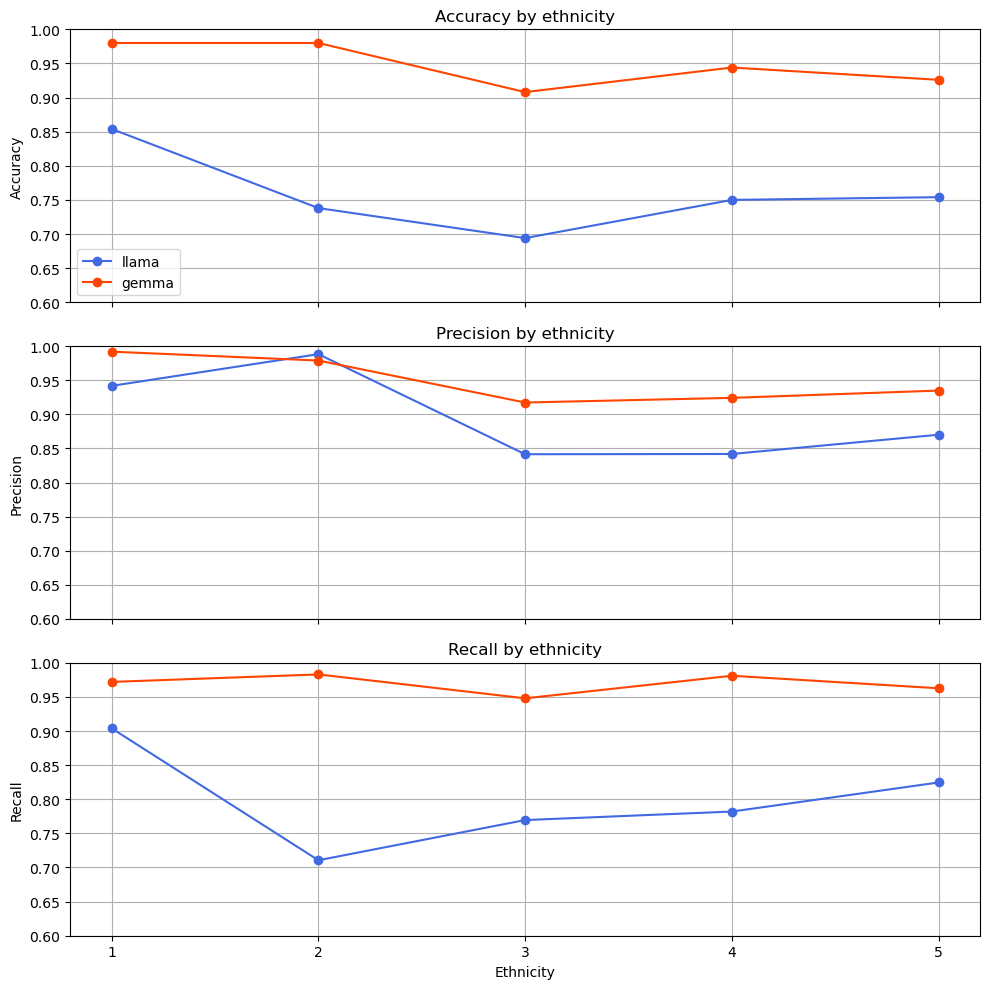

In [7]:
import matplotlib.pyplot as plt

# Plot each metric in a subplot
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
metric_names = ["accuracy", "precision", "recall"]
colors = {"llama": "royalblue", "gemma": "orangered"}

for i, metric in enumerate(metric_names):
    ax = axes[i]
    for model in ["llama", "gemma"]:
        # Sort the model data by ethnicity
        model_data = metrics_df[metrics_df["model"] == model].sort_values(by="ethnicity")
        ax.plot(model_data["ethnicity"], model_data[metric], marker='o', label=model, color=colors[model])
    
    ax.set_ylabel(metric.capitalize())
    ax.set_ylim(0.6, 1)
    ax.set_title(f"{metric.capitalize()} by ethnicity")
    ax.grid(True)

# Set x-axis ticks to 1 through 5 on the bottom subplot
axes[-1].set_xlabel("Ethnicity")
axes[-1].set_xticks([1, 2, 3, 4, 5])

# Show legend only on the top subplot
axes[0].legend()

plt.tight_layout()
plt.show()




# Genders

In [32]:
import numpy as np
from sklearn.utils import resample

def precision_score(y_true, y_pred, pos_label):
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)

    tp = np.sum((y_pred == pos_label) & (y_true == pos_label))
    fp = np.sum((y_pred == pos_label) & (y_true != pos_label))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall_score(y_true, y_pred, pos_label):
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    tp = np.sum((y_pred == pos_label) & (y_true == pos_label))
    fn = np.sum((y_pred != pos_label) & (y_true == pos_label))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def accuracy_score(y_true, y_pred, pos_label):
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    tp = np.sum((y_pred == pos_label) & (y_true == pos_label))
    tn = np.sum((y_pred != pos_label) & (y_true != pos_label))
    n = 2500
    return (tp + tn) / n if n > 0 else 0

def bootstrap_ci_2(data, col1, col2, n_bootstrap=1000, ci=95, pos_label=1):
    acc1_list = []
    acc2_list = []
    prec1_list = []
    prec2_list = []
    rec1_list = []
    rec2_list = []

    for _ in range(n_bootstrap):
        sample = resample(data)
        y_true = sample["actual_gender"].values
        y_pred1 = sample[col1].values
        y_pred2 = sample[col2].values

        # Accuracy difference
        acc1 = accuracy_score(y_true, y_pred1, pos_label)
        acc2 = accuracy_score(y_true, y_pred2, pos_label)
        acc1_list.append(acc1)
        acc2_list.append(acc2)

        # Precision & Recall
        prec1 = precision_score(y_true, y_pred1, pos_label)
        prec2 = precision_score(y_true, y_pred2, pos_label)
        rec1 = recall_score(y_true, y_pred1, pos_label)
        rec2 = recall_score(y_true, y_pred2, pos_label)

        prec1_list.append(prec1)
        prec2_list.append(prec2)
        rec1_list.append(rec1)
        rec2_list.append(rec2)

    def ci_bounds(metric_list):
        lower = np.percentile(metric_list, (100 - ci) / 2)
        upper = np.percentile(metric_list, 100 - (100 - ci) / 2)
        return np.mean(metric_list), (lower, upper)

    return {
        "accuracy1": ci_bounds(acc1_list),
        "accuracy2": ci_bounds(acc2_list),
        "precision1": ci_bounds(prec1_list),
        "precision2": ci_bounds(prec2_list),
        "recall1": ci_bounds(rec1_list),
        "recall2": ci_bounds(rec2_list),
    }

for g, label in genders.items():
    results = bootstrap_ci_2(
        df.copy(),  # ✅ use the full data
        "gemma_pred_bin", 
        "llama_pred_bin", 
        n_bootstrap=1000, 
        ci=95,
        pos_label=g  # the class we're analyzing
    )
    print(f"\nGender: {label}")
    print(f"  Gemma Accuracy = {results['accuracy1'][0]:.3f}, CI = [{results['accuracy1'][1][0]:.3f}, {results['accuracy1'][1][1]:.3f}]")
    print(f"  Llama Accuracy = {results['accuracy2'][0]:.3f}, CI = [{results['accuracy2'][1][0]:.3f}, {results['accuracy2'][1][1]:.3f}]")
    print(f"  Gemma Precision = {results['precision1'][0]:.3f}, CI = [{results['precision1'][1][0]:.3f}, {results['precision1'][1][1]:.3f}]")
    print(f"  Llama Precision = {results['precision2'][0]:.3f}, CI = [{results['precision2'][1][0]:.3f}, {results['precision2'][1][1]:.3f}]")
    print(f"  Gemma Recall = {results['recall1'][0]:.3f}, CI = [{results['recall1'][1][0]:.3f}, {results['recall1'][1][1]:.3f}]")
    print(f"  Llama Recall = {results['recall2'][0]:.3f}, CI = [{results['recall2'][1][0]:.3f}, {results['recall2'][1][1]:.3f}]")


C:\Users\Bruger\AppData\Local\Temp\ipykernel_15284\1688237592.py:20: RuntimeWarning: invalid value encountered in cast
  y_pred = y_pred.astype(int)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_15284\1688237592.py:5: RuntimeWarning: invalid value encountered in cast
  y_pred = y_pred.astype(int)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_15284\1688237592.py:13: RuntimeWarning: invalid value encountered in cast
  y_pred = y_pred.astype(int)



Gender: Male
  Gemma Accuracy = 0.952, CI = [0.943, 0.960]
  Llama Accuracy = 0.848, CI = [0.834, 0.861]
  Gemma Precision = 0.977, CI = [0.968, 0.985]
  Llama Precision = 0.976, CI = [0.966, 0.986]
  Gemma Recall = 0.927, CI = [0.912, 0.941]
  Llama Recall = 0.717, CI = [0.693, 0.741]

Gender: Female
  Gemma Accuracy = 0.958, CI = [0.950, 0.966]
  Llama Accuracy = 0.854, CI = [0.840, 0.867]
  Gemma Precision = 0.948, CI = [0.935, 0.959]
  Llama Precision = 0.892, CI = [0.874, 0.909]
  Gemma Recall = 0.968, CI = [0.959, 0.978]
  Llama Recall = 0.800, CI = [0.777, 0.821]


In [12]:
# Overall McNemar's test (across all samples with valid predictions)
stat, p = run_mcnemar_test(df)
print(f" Overall McNemar's test:\n  Statistic = {stat}, p-value = {p:.2e}\n")

# Run McNemar's test and accuracy CI separately for each gender
genders = {0: "Male", 1: "Female"}

for g, label in genders.items():
    gender_subset = df[df["actual_gender"] == g]
    
    # McNemar test
    stat, p = run_mcnemar_test(gender_subset)
    print(f" Gender: {label} — McNemar's test:\n  Statistic = {stat}, p-value = {p:.2e}")
    
    # Accuracy difference
    gemma_acc = gender_subset["gemma_correct"].mean()
    llama_acc = gender_subset["llama_correct"].mean()
    acc_diff = gemma_acc - llama_acc
    
    # Bootstrap 95% CI
    diffs = []
    for _ in range(10000):
        sample = resample(gender_subset)
        diff = sample["gemma_correct"].mean() - sample["llama_correct"].mean()
        diffs.append(diff)
    lower = np.percentile(diffs, 2.5)
    upper = np.percentile(diffs, 97.5)

    print(f"   Accuracy difference = {acc_diff:.4f}")
    print(f"   95% CI = ({lower:.4f}, {upper:.4f})\n")

# Overall accuracy difference and 95% CI
gemma_acc = df["gemma_correct"].mean()
llama_acc = df["llama_correct"].mean()
acc_diff = gemma_acc - llama_acc
diffs = []
for _ in range(10000):
    sample = resample(df)
    diff = sample["gemma_correct"].mean() - sample["llama_correct"].mean()
    diffs.append(diff)
lower = np.percentile(diffs, 2.5)
upper = np.percentile(diffs, 97.5)

print(f" Overall Accuracy difference = {acc_diff:.4f}")
print(f"   95% CI = ({lower:.4f}, {upper:.4f})")

 Overall McNemar's test:
  Statistic = 39.0, p-value = 1.57e-106

 Gender: Male — McNemar's test:
  Statistic = 14.0, p-value = 2.00e-65
   Accuracy difference = 0.2099
   95% CI = (0.1863, 0.2344)

 Gender: Female — McNemar's test:
  Statistic = 25.0, p-value = 1.83e-43
   Accuracy difference = 0.1687
   95% CI = (0.1452, 0.1930)

 Overall Accuracy difference = 0.1896
   95% CI = (0.1732, 0.2064)
